In [1]:
#!pip install pykeen==1.11.0
#!pip install class-resolver==0.5.4
#!pip install typing-extensions==4.12.2

In [1]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline_from_path
#from pykeen.models.predict import predict_tail_scores, predict_head_scores
from pykeen.predict import predict_triples, predict_target
from pykeen.evaluation import ClassificationEvaluator, RankBasedEvaluator

import os
import torch
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU device: NVIDIA GeForce RTX 3060 Ti


# 1. Load and Preprocess Data

In [4]:
working_dir = os.getcwd()
train_news_file = os.path.join(working_dir, 'data','train','news.tsv')
train_behavior_file = os.path.join(working_dir, 'data','train','behaviors.tsv')
train_entity_embedding_file = os.path.join(working_dir, 'data','train','entity_embedding.vec')
train_triplets_file = os.path.join(working_dir, 'data','train','triplets.tsv')

train_news_with_sentiment_file = os.path.join(working_dir, 'data','train','news_with_sentiment.csv')

In [5]:
# Load behaviors data (user-article interactions)
behaviors = pd.read_csv(train_behavior_file,
                       sep='\t',
                       header=None,
                       names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Drop NA values
behaviors = behaviors.dropna(subset=['user_id','history','impressions'])

# Process click history to get user-article pairs
user_article_pairs = []
for _, row in behaviors.iterrows():
    if pd.notna(row['history']):
        for article in row['history'].split():
            user_article_pairs.append((row['user_id'], article))

# Remove duplicates
user_article_df = pd.DataFrame(user_article_pairs, columns=['user_id', 'article_id']).drop_duplicates()

# Load meta data (article metadata)
news = pd.read_csv(train_news_file,
                  sep='\t',
                  header=None,
                  names=['article_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities', 'sentiment'])

# Create article-category relationships and remove duplicates
article_category_df = news[['article_id', 'category', 'subcategory']].drop_duplicates()

# Load sentiment data (team produced metadata)
news_tone = pd.read_csv(train_news_with_sentiment_file,
                  header=None,
                  names=['article_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities', 'sentiment'])

# Create article-category relationships and remove duplicates
article_tone_df = news[['article_id', 'sentiment']].drop_duplicates()

# 2. Create Triples

In [6]:
# Filter users who have at least 5 clicks
active_users = user_article_df['user_id'].value_counts()
active_users = active_users[active_users >= 5].index.tolist()

user_article_active = user_article_df[user_article_df['user_id'].isin(active_users)]

# Sample 50,000 interactions
sampled_user_article = user_article_active.sample(n=50000, random_state=42)

# User-article triples (user clicks article)
user_article_triples = [(user, 'CLICKS', article) for user, article in sampled_user_article[['user_id', 'article_id']].values]

# Article-category triples (article belongs to category)
article_category_triples = [(row['article_id'], 'BELONGS_TO', row['category'])
                           for _, row in article_category_df.iterrows()]

# Article-subcategory triples
article_subcategory_triples = [(row['article_id'], 'BELONGS_TO_SUBCATEGORY', row['subcategory'])
                               for _, row in article_category_df.iterrows()]

# Article-subcategory triples
article_tone_triples = [(row['article_id'], 'HAS_TONE', row['sentiment'])
                               for _, row in article_tone_df.iterrows()]

# Create extra meta data triples
entity_triples = []
for _, row in news.iterrows():
    # Parse title entities
    if pd.notna(row['title_entities']):
        entities = json.loads(row['title_entities'])
        for entity in entities:
            entity_triples.append((row['article_id'], 'HAS_ENTITY', entity['WikidataId']))
            entity_triples.append((row['article_id'], 'IS_WIKI_TYPE', entity['Type']))

# Combine all triples
triples = user_article_triples + article_category_triples + article_subcategory_triples + entity_triples
triples_tone = user_article_triples + article_category_triples + article_subcategory_triples + entity_triples + article_tone_triples

# 3. Train TransE Models
### 3.1 MIND Provided Features and MetaData

In [7]:
tf = TriplesFactory.from_labeled_triples(
    np.array(triples),
    create_inverse_triples=True, 
    # Create inverse relations
    )

training, testing = tf.split([.8,.2], random_state=256)
evaluator = RankBasedEvaluator()

In [ ]:
# GPU-optimized pipeline
result = pipeline(
    training=training,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=10),
    training_kwargs=dict(
        num_epochs=25,
        batch_size=512,
    ),
    optimizer_kwargs=dict(lr=0.01), 
    random_seed=256,
    device='gpu',
    negative_sampler='basic',
    negative_sampler_kwargs=dict(num_negs_per_pos=2),
    evaluator=evaluator,
    evaluator_kwargs=dict(filtered=True),
    evaluation_kwargs=dict(device=torch.device('cuda')),
    use_tqdm=True  # Show progress bars
)

# Save the model for later use
result.save_to_directory(os.path.join(working_dir, 'results',))

### 3.1 Addition of Team Generated Sentiment Features

In [9]:
tf_sentiment = TriplesFactory.from_labeled_triples(
    np.array(triples_tone),
    create_inverse_triples=True  # Create inverse relations
)

training_sentiment, testing_sentiment = tf_sentiment.split(random_state=256)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [163026, 63248]


In [ ]:
# GPU-optimized pipeline
result_tone = pipeline(
    training=training_sentiment,
    testing=testing_sentiment,
    model='TransE',
    model_kwargs=dict(embedding_dim=10),
    training_kwargs=dict(
        num_epochs=25,
        batch_size=512,  # Larger batches better for GPU
    ),
    optimizer_kwargs=dict(lr=0.01),  # Learning rate
    random_seed=256,
    device='gpu',  # This is the key change for GPU
    negative_sampler='basic',
    negative_sampler_kwargs=dict(num_negs_per_pos=10),
    evaluator_kwargs=dict(filtered=True),
    use_tqdm=True  # Show progress bars
)

# Save the model for later use
result.save_to_directory(os.path.join(working_dir, 'result_tone',))

# Evaluation
## MRR
### No Sentiment Features

In [13]:
model = result.model
# Access specific metrics
print("Mean Rank:", result.metric_results.get_metric('mean_rank'))
print("Mean Reciprocal Rank (MRR):", result.metric_results.get_metric('mean_reciprocal_rank'))
print("Hits@1:", result.metric_results.get_metric('hits_at_1')) 
print("Hits@3:", result.metric_results.get_metric('hits_at_3'))
print("Hits@10:", result.metric_results.get_metric('hits_at_10'))

Mean Rank: 7728.9228515625
Mean Reciprocal Rank (MRR): 0.022526569664478302
Hits@1: 0.008614507850241546
Hits@3: 0.020606884057971016
Hits@10: 0.047271286231884056


loss: 0.0001 41003.828125, loss .001 Mean Rank: 41090.44921875, 17120 ComplEx-> TransE, 16409.64453125, 16730 added negative samplerkwargs, embeddings 100->50, 16660, 14567 loss 0.001 -> 01, 16859 batch size 256 -> 128, 14105 batch size 128 - 256 epochs 5->25, 11578 added subcategory, 20820 batch 256 -> 512 loss 0.01 -> 0.001,  16377 -> 9334

In [14]:
# Access specific metrics
print("Mean Rank:", result_tone.metric_results.get_metric('mean_rank'))
print("Mean Reciprocal Rank (MRR):", result_tone.metric_results.get_metric('mean_reciprocal_rank'))
print("Hits@1:", result_tone.metric_results.get_metric('hits_at_1')) 
print("Hits@3:", result_tone.metric_results.get_metric('hits_at_3'))
print("Hits@10:", result_tone.metric_results.get_metric('hits_at_10'))

Mean Rank: 5257.298828125
Mean Reciprocal Rank (MRR): 0.09234735369682312
Hits@1: 0.054381166202883885
Hits@3: 0.10758442954717935
Hits@10: 0.16615545155578043


## AUC
The Pykeen built in evaluation function crashes when evaluating this model. Klaude was used to generate the following code evluating the model using Sklearn Evaluator

In [ ]:
#AUC_evaluator = ClassificationEvaluator()
#test_triples_tensor = tf.map_triples(testing.triples[1000:]) #reducing test size for memory
# Evaluate
#auc_results = AUC_evaluator.evaluate(model, test_triples_tensor, batch_size=128, use_tqdm=True)

In [25]:
# Klaude Generated
# Function to compute scores for triples
def compute_scores(model, triples, device='cpu'):
    """
    Compute scores for triples using the PyKEEN model.
    
    Args:
        model: A trained PyKEEN model
        triples: numpy array or tensor of shape (n, 3) with [head, relation, tail] format
        device: Device to use for computation
        
    Returns:
        numpy array of scores
    """
    # Convert to tensor if not already
    if not isinstance(triples, torch.Tensor):
        triples = torch.tensor(triples, dtype=torch.long, device=device)
    else:
        triples = triples.to(device)
    
    # Get batch size that fits in memory
    batch_size = 1024
    num_triples = triples.shape[0]
    
    scores = []
    
    # Process in batches to avoid memory issues
    with torch.no_grad():
        for start_idx in tqdm(range(0, num_triples, batch_size), desc="Computing scores"):
            end_idx = min(start_idx + batch_size, num_triples)
            batch = triples[start_idx:end_idx]
            
            # PyKEEN score computation
            batch_scores = model.score_hrt(batch).cpu().numpy()
            scores.append(batch_scores)
    
    return np.concatenate(scores)

In [26]:
# Klaude Generated
# Function to generate negative samples
def generate_negative_samples(positive_triples, num_entities, num_samples_per_positive=1, 
                              corruption_scheme='tail', filter_positives=None):
    """
    Generate negative samples by corrupting either head or tail entities.
    
    Args:
        positive_triples: numpy array of shape (n, 3) with positive triples [head, relation, tail]
        num_entities: Total number of entities in the knowledge graph
        num_samples_per_positive: Number of negative samples to generate per positive triple
        corruption_scheme: Either 'head', 'tail', or 'both'
        filter_positives: Set of positive triples to filter out from generated negatives
        
    Returns:
        numpy array of negative triples
    """
    np.random.seed(42)
    num_triples = len(positive_triples)
    negative_triples = []
    
    for idx in tqdm(range(num_triples), desc="Generating negative samples"):
        h, r, t = positive_triples[idx]
        
        for _ in range(num_samples_per_positive):
            if corruption_scheme == 'head' or (corruption_scheme == 'both' and np.random.random() > 0.5):
                # Corrupt head
                neg_h = np.random.randint(0, num_entities)
                while neg_h == h or (filter_positives is not None and (neg_h, r, t) in filter_positives):
                    neg_h = np.random.randint(0, num_entities)
                negative_triples.append([neg_h, r, t])
            else:
                # Corrupt tail
                neg_t = np.random.randint(0, num_entities)
                while neg_t == t or (filter_positives is not None and (h, r, neg_t) in filter_positives):
                    neg_t = np.random.randint(0, num_entities)
                negative_triples.append([h, r, neg_t])
    
    return np.array(negative_triples)

In [27]:
# Klaude Generated
# Main function to evaluate the model
def evaluate_roc_auc(model, test_triples, num_entities, device='cpu', num_negatives_per_positive=10,
                    corruption_scheme='tail', filter_positives=None, plot=True):
    """
    Evaluate the model using ROC AUC.
    
    Args:
        model: Trained PyKEEN model
        test_triples: Test set triples
        num_entities: Total number of entities
        device: Device to use for computation
        num_negatives_per_positive: Number of negative samples per positive sample
        corruption_scheme: Scheme for generating negative samples
        filter_positives: Set of positive triples to filter out from negatives
        plot: Whether to plot the ROC curve
        
    Returns:
        AUC score, FPR, TPR, thresholds
    """
    print("Generating negative samples...")
    negative_triples = generate_negative_samples(
        test_triples, 
        num_entities, 
        num_samples_per_positive=num_negatives_per_positive,
        corruption_scheme=corruption_scheme,
        filter_positives=filter_positives
    )
    
    print(f"Scoring {len(test_triples)} positive triples...")
    positive_scores = compute_scores(model, test_triples, device)
    
    print(f"Scoring {len(negative_triples)} negative triples...")
    negative_scores = compute_scores(model, negative_triples, device)
    
    # Combine scores and create labels (1 for positive, 0 for negative)
    all_scores = np.concatenate([positive_scores, negative_scores])
    all_labels = np.concatenate([np.ones(len(positive_scores)), np.zeros(len(negative_scores))])
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    print(f"ROC AUC: {roc_auc:.4f}")
    
    if plot:
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.show()
    
    return roc_auc, fpr, tpr, thresholds

In [28]:
# Klaude Generated
# Evaluation using a TriplesFactory
def evaluate_with_triples_factory(model, test_triples_factory, device='cpu', 
                                 corruption_scheme='tail', filter_triples=None):
    """
    Evaluate model on test data from a PyKEEN TriplesFactory
    
    Args:
        model: Trained PyKEEN model
        test_triples_factory: PyKEEN TriplesFactory containing test triples
        device: Computation device
        corruption_scheme: How to corrupt triples ('head', 'tail', or 'both')
        filter_triples: Optional additional triples to filter during negative sampling
        
    Returns:
        ROC AUC score and curve data
    """
    # Get test triples from TriplesFactory
    test_triples = test_triples_factory.mapped_triples.numpy()
    
    # Get entity and relation maps for reference
    entity_to_id = test_triples_factory.entity_to_id
    relation_to_id = test_triples_factory.relation_to_id
    
    # Number of entities
    num_entities = test_triples_factory.num_entities
    
    # Create set of all positive triples for filtering
    all_positives = set()
    for h, r, t in test_triples:
        all_positives.add((h, r, t))
    
    # Add any additional triples to filter (like training triples)
    if filter_triples is not None:
        for h, r, t in filter_triples:
            all_positives.add((h, r, t))
    
    print(f"Evaluating on {len(test_triples)} triples from TriplesFactory")
    print(f"Using {corruption_scheme} corruption scheme")
    
    # Run evaluation
    return evaluate_roc_auc(
        model=model,
        test_triples=test_triples,
        num_entities=num_entities,
        device=device,
        corruption_scheme=corruption_scheme,
        filter_positives=all_positives,
        plot=True
    )

In [29]:
# Klaude Generated
# Example usage for MIND dataset with user_ids to article_ids prediction
def evaluate_mind_dataset(model, test_data, entity_mapper, relation_id, device='cpu'):
    """
    Evaluate model on MIND dataset for user -> article recommendations
    
    Args:
        model: Trained PyKEEN model
        test_data: DataFrame or list of (user_id, article_id) pairs for testing
        entity_mapper: Dictionary mapping user/article IDs to entity IDs used in the model
        relation_id: The relation ID used for user-clicks-article relationship
        device: Computation device
        
    Returns:
        ROC AUC score and curve data
    """
    # Convert test data to triples format
    test_triples = []
    
    if isinstance(test_data, pd.DataFrame):
        for _, row in test_data.iterrows():
            user_entity_id = entity_mapper.get(f"user_{row['user_id']}")
            article_entity_id = entity_mapper.get(f"article_{row['article_id']}")
            
            if user_entity_id is not None and article_entity_id is not None:
                test_triples.append([user_entity_id, relation_id, article_entity_id])
    else:
        # Assuming test_data is a list of (user_id, article_id) tuples
        for user_id, article_id in test_data:
            user_entity_id = entity_mapper.get(f"user_{user_id}")
            article_entity_id = entity_mapper.get(f"article_{article_id}")
            
            if user_entity_id is not None and article_entity_id is not None:
                test_triples.append([user_entity_id, relation_id, article_entity_id])
    
    test_triples = np.array(test_triples)
    
    # Get total entity count from model
    num_entities = model.num_entities
    
    # Create set of all positive triples for filtering during negative sampling
    all_positives = set()
    for h, r, t in test_triples:
        all_positives.add((h, r, t))
    
    print(f"Evaluating on {len(test_triples)} user-article interactions")
    
    # Run evaluation (using 'tail' corruption because we're predicting articles)
    return evaluate_roc_auc(
        model=model,
        test_triples=test_triples,
        num_entities=num_entities,
        device=device,
        corruption_scheme='tail',  # We want to corrupt article entities
        filter_positives=all_positives,
        plot=True
    )

Evaluating using TriplesFactory...
Evaluating on 52992 triples from TriplesFactory
Using tail corruption scheme
Generating negative samples...


Generating negative samples:   0%|          | 0/52992 [00:00<?, ?it/s]

Scoring 52992 positive triples...


Computing scores:   0%|          | 0/52 [00:00<?, ?it/s]

Scoring 529920 negative triples...


Computing scores:   0%|          | 0/518 [00:00<?, ?it/s]

ROC AUC: 0.3858


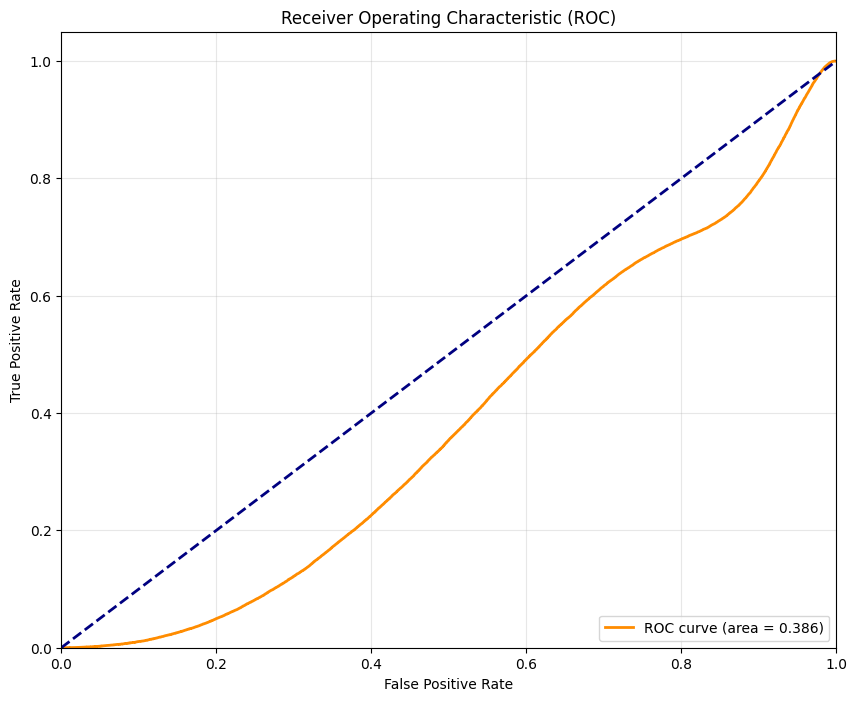

Final ROC AUC with TriplesFactory: 0.3858


In [30]:
# Klaude Generated
# This is an example - replace with your actual code

# Option 1: Using a TriplesFactory directly
# ----------------------------------------

# Load your trained model
from pykeen.models import TransE
model = result.model

# Load your test triples factory
test_triples_factory = testing  # Replace with your actual test TriplesFactory

# Get the training triples factory (optional, for filtering)
train_triples_factory = training  # Replace with your actual train TriplesFactory
train_triples = train_triples_factory.mapped_triples.numpy()  # For filtering

# Run evaluation using the TriplesFactory directly
print("Evaluating using TriplesFactory...")
roc_auc, fpr, tpr, thresholds = evaluate_with_triples_factory(
    model=model,
    test_triples_factory=test_triples_factory,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    corruption_scheme='tail',  # Assuming we're predicting articles (tail entities)
    filter_triples=train_triples  # Optional: filter out training triples from negative samples
)

print(f"Final ROC AUC with TriplesFactory: {roc_auc:.4f}")

### Evaluation with Sentiment Features

Evaluating using TriplesFactory...
Evaluating on 63248 triples from TriplesFactory
Using tail corruption scheme
Generating negative samples...


Generating negative samples:   0%|          | 0/63248 [00:00<?, ?it/s]

Scoring 63248 positive triples...


Computing scores:   0%|          | 0/62 [00:00<?, ?it/s]

Scoring 632480 negative triples...


Computing scores:   0%|          | 0/618 [00:00<?, ?it/s]

ROC AUC: 0.4027


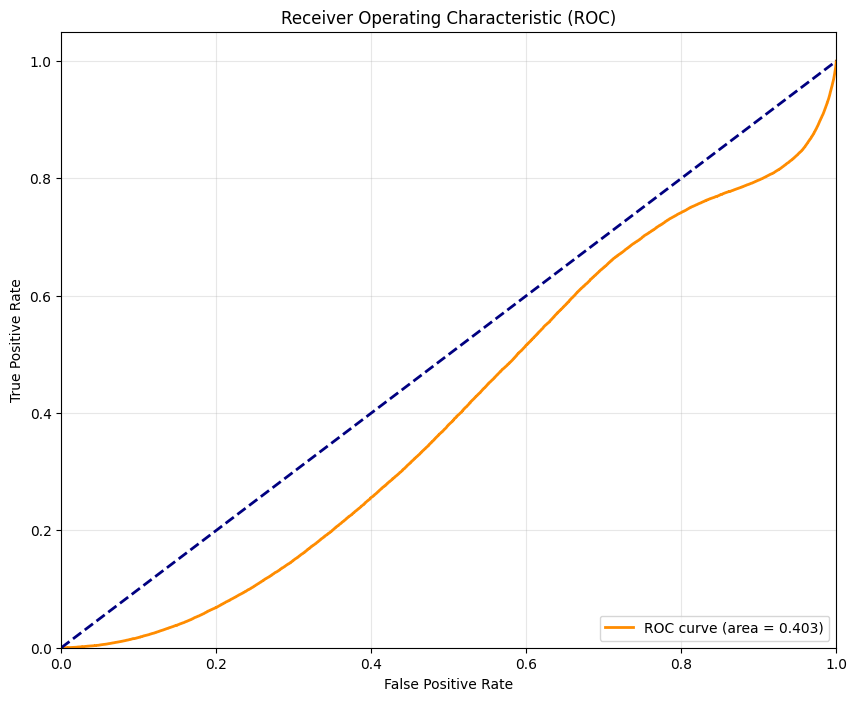

Final ROC AUC with TriplesFactory: 0.4027


In [31]:
# This is an example - replace with your actual code

# Option 1: Using a TriplesFactory directly
# ----------------------------------------

# Load your trained model
from pykeen.models import TransE
model = result_tone.model

# Load your test triples factory
test_triples_factory = testing_sentiment  # Replace with your actual test TriplesFactory

# Get the training triples factory (optional, for filtering)
train_triples_factory = training_sentiment  # Replace with your actual train TriplesFactory
train_triples = train_triples_factory.mapped_triples.numpy()  # For filtering

# Run evaluation using the TriplesFactory directly
print("Evaluating using TriplesFactory...")
roc_auc, fpr, tpr, thresholds = evaluate_with_triples_factory(
    model=model,
    test_triples_factory=test_triples_factory,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    corruption_scheme='tail',  # Assuming we're predicting articles (tail entities)
    filter_triples=train_triples  # Optional: filter out training triples from negative samples
)

print(f"Final ROC AUC with TriplesFactory: {roc_auc:.4f}")